In [2]:
# import packages
import os,sys
sys.path.insert(0, '../monod/src/')

import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr

from functools import reduce

# sc
import loompy as lp
import anndata

# colors
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# import Monod
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

# line of "best fit"
from sklearn.linear_model import LinearRegression

In [3]:
# plotting colors
# green, blue, purple, red, pink
colors_rep1 = ['#74c476','#6baed6','#9e9ac8','#fd8d3c','#feebe2']
colors_rep2 = ['238b45','#2171b5','#6a51a3','#d94701','#fbb4b9']

In [4]:
# qc function
def run_qc(sr,sd,n_cores=10):

    sr.find_sampling_optimum()
#     sr.plot_landscape(ax1)

#     sr.plot_KL(ax1)

#     sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)
#     sr.resample_opt_viz()
#     sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,viz=False) 

    sr.compute_sigma(sd,num_cores=n_cores)
#     sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
#     sr.plot_param_marg()
#     monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()

Load in search data object.

In [5]:
c = 'mESC'
model = 'Bursty'
noise = 'Poisson'
gridsize='6x7'
path = f'./fits/mc_240223_026_khateb_1/{c}'
sr_arr = monod.analysis.load_search_results(f'{path}/{model}_{noise}_{gridsize}/grid_scan_results.res')
sr_arr.find_sampling_optimum()
sd_arr = monod.analysis.load_search_data(f'{path}/raw.sd')
sd_arr.n_cells


12167

In [6]:
run_qc(sr_arr,sd_arr)

/home/tara/maria/monod/reviews/../monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


In [7]:
accepted_genes = sr_arr.gene_names[~sr_arr.rejected_genes]



In [8]:
len(accepted_genes)

1964

In [9]:
sr_arr.n_cells

12167

# Compare inferred burst sizes to Takei

In [11]:
# load in data from seqFISH
path = './data/takei'
with open(f'{path}/E14_rep1_seqFISH_burst_sizes_all','rb') as file:
    es_rep1_all = pickle.load(file)
with open(f'{path}/E14_rep2_seqFISH_burst_sizes_all','rb') as file:
    es_rep2_all = pickle.load(file)

    
es_rep1_df_all = pd.DataFrame({
    'gene_name' : es_rep1_all['gene_name'],
    'GENE_NAME' : [g.upper() for g in es_rep1_all['gene_name']],
    'burst_size_1' : es_rep1_all['burst_size'].mean(axis=0),
    'burst_size_variance_1' : es_rep1_all['burst_size'].var(axis=0),
    'adj_intron_mean' : es_rep1_all['adj_intron_counts'].mean(axis=0),
    'intron_mean' : es_rep1_all['intron_counts'].mean(axis=0),
})

es_rep2_df_all = pd.DataFrame({
    'gene_name' : es_rep2_all['gene_name'],
    'GENE_NAME' : [g.upper() for g in es_rep2_all['gene_name']],
    'burst_size_2' : es_rep2_all['burst_size'].mean(axis=0),
    'burst_size_variance_2' : es_rep2_all['burst_size'].var(axis=0),
    'adj_intron_mean_2' : es_rep2_all['adj_intron_counts'].mean(axis=0),
    'intron_mean_2' : es_rep2_all['intron_counts'].mean(axis=0),
})

In [12]:
filt2 = [g in es_rep1_df_all.GENE_NAME.values for g in accepted_genes]
monod_genes = accepted_genes[filt2]
monod_bs = 10**sr_arr.phys_optimum[:,0][~sr_arr.rejected_genes][filt2]
monod_bs_error = sr_arr.sigma[:,0][~sr_arr.rejected_genes][filt2]
monod_df = pd.DataFrame({'GENE_NAME' : monod_genes,
                         'burst_size' : monod_bs,
                         'unspliced_mean' : sd_arr.layers[0].mean(axis=1)[~sr_arr.rejected_genes][filt2],
                         'burst_size_error' : monod_bs_error
                          })

In [13]:
data_frames = [es_rep1_df_all,es_rep2_df_all ,monod_df]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['GENE_NAME']), data_frames)

In [26]:
df_save = {}

df_save['gene_name'] = df_merged['gene_name_x'].values
df_save['seqFISH+ burst size rep1'] = df_merged['burst_size_1'] 
df_save['seqFISH+ adj intron mean rep1'] = df_merged['adj_intron_mean']
df_save['seqFISH+ intron mean rep1'] = df_merged['intron_mean']
df_save['seqFISH+ burst size rep2'] =  df_merged['burst_size_2'] 
df_save['seqFISH+ adj intron mean rep2'] = df_merged['adj_intron_mean_2']
df_save['seqFISH+ intron mean rep2'] = df_merged['intron_mean_2']
df_save['Monod burst size'] = df_merged['burst_size']
df_save['10xv3 unspliced mean'] = df_merged['unspliced_mean']
df_save['Monod burst size error'] = df_merged['burst_size_error']

df_save = pd.DataFrame(df_save)
df_save.to_csv('takei_khateb_comparison.csv')

0.332976195544386
0.34722835501646


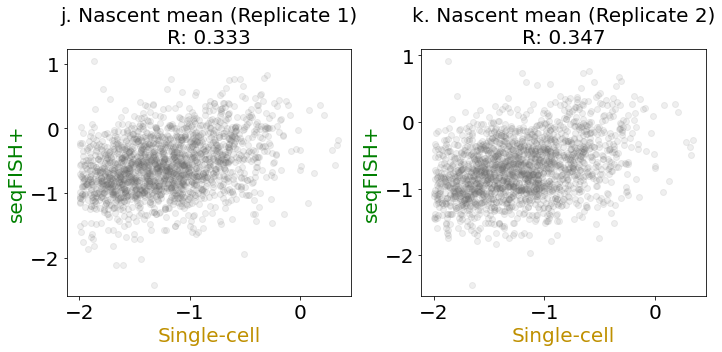

In [14]:
eps=1e-18
fs = 20 
lw = 3 
c_identity = 'k'
c_genes = 'dimgrey'
alpha_genes = 0.1
sc_color = np.asarray([191,144,0])/255

fig,ax = plt.subplots(1,2,figsize=(10,5))

title1 = 'j. Nascent mean'
title2 = 'k. Nascent mean'
x_column = 'unspliced_mean'
y_column = 'adj_intron_mean'
# title1 = r'l. $\log_{10}$ burst size'
# title2 = r'm. $\log_{10}$ burst size'
# x_column = 'burst_size'
# y_column = 'burst_size_1'


x = np.log10(df_merged[x_column].values)
y = np.log10(df_merged[y_column].values)
dx = df_merged['burst_size_error'].values

# ax[0].errorbar(x,y,xerr = dx,c=c_genes,linestyle="None",alpha=alpha_genes)
ax[0].scatter(x,y,c=c_genes,linestyle="None",alpha=alpha_genes)

r_log,p_ = pearsonr((np.log10(df_merged[x_column])),
                 np.log10(df_merged[y_column]))
print(r_log)

# r,p_ = pearsonr(((df_merged[x_column]+eps)),
#                  (df_merged[y_column]+eps))


ax[0].set_xlabel('Single-cell',fontsize=fs,color=sc_color)
ax[0].set_ylabel('seqFISH+',fontsize=fs,color='green')
ax[0].set_title(title1+f' (Replicate 1)\nR: {r_log:.3f}',fontsize=fs)

# add best-fit line
model = LinearRegression().fit(x.reshape(-1,1), y)
x_fit = np.linspace(min(x), max(x), 100).reshape(-1,1)
y_fit = model.predict(x_fit)
# ax[0].plot(x_fit,y_fit,'--',color=c_identity,linewidth=lw)

# x_column = 'burst_size'
# y_column = 'burst_size_2'
x_column = 'unspliced_mean'
y_column = 'adj_intron_mean_2'

x = np.log10(df_merged[x_column].values)
y = np.log10(df_merged[y_column].values)
dx = df_merged['burst_size_error']

# ax[1].errorbar(x,y,xerr = dx,c=c_genes,linestyle="None",alpha=alpha_genes)
ax[1].scatter(x,y,c=c_genes,linestyle="None",alpha=alpha_genes)

r_log,p_ = pearsonr((np.log10(df_merged[x_column])),
                 np.log10(df_merged[y_column]))
print(r_log)

# r,p_ = pearsonr(((df_merged[x_column]+eps)),
#                  (df_merged[y_column]+eps))


ax[1].set_xlabel('Single-cell',fontsize=fs,color=sc_color)
ax[1].set_ylabel('seqFISH+',fontsize=fs,color='green')
ax[1].set_title(title2+f' (Replicate 2)\nR: {r_log:.3f}',fontsize=fs)


# add best-fit line
model = LinearRegression().fit(x.reshape(-1,1), y)
x_fit = np.linspace(min(x), max(x), 100).reshape(-1,1)
y_fit = model.predict(x_fit)
# ax[1].plot(x_fit,y_fit,'--',color=c_identity,linewidth=lw)



plt.tight_layout()
# plt.savefig('./figs/khateb_vs_monod_burst_size_scatter.png',dpi=450,bbox_inches='tight');

In [1]:
df_merged

NameError: name 'es_rep' is not defined